In [1]:
import os
import sys

current_dir = os.path.dirname(os.path.abspath('.'))
project_root = os.path.abspath(os.path.join(current_dir, '..', '..'))
dendritex_path = os.path.join(project_root, 'braincell')
sys.path.insert(0, dendritex_path)
import os
import time
import brainstate 
import braintools 
import brainunit as u
import jax
import matplotlib.pyplot as plt
import numpy as np
import braincell as dx
import jax.numpy as jnp

brainstate .environ.set(precision=64)
#jax.config.update("jax_disable_jit", True)

In [2]:
# set visible GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
devices = jax.devices()
print("available devices:", devices)

available devices: [CudaDevice(id=0)]


In [3]:
loaded_params = np.load('golgi_morphology.npz')

connection = loaded_params['connection']
L = loaded_params['L']  # um
diam = loaded_params['diam']  # um
Ra = loaded_params['Ra']  # ohm * cm
cm = loaded_params['cm']  # uF / cm ** 2

n_neuron = 1
n_compartments = len(L)
size = (n_neuron, n_compartments)

index_soma = loaded_params['index_soma']
index_axon = loaded_params['index_axon']
index_dend_basal = loaded_params['index_dend_basal']
index_dend_apical = loaded_params['index_dend_apical']

## conductvalues 
conductvalues = 1e3 * np.array([

    0.00499506303209, 0.01016375552607, 0.00247172479141, 0.00128859564935,
    3.690771983E-05, 0.0080938853146, 0.01226052748146, 0.01650689958385,
    0.00139885617712, 0.14927733727426, 0.00549507510519, 0.14910988921938,
    0.00406420380423, 0.01764345789036, 0.10177335775222, 0.0087689418803,
    3.407734319E-05, 0.0003371456442, 0.00030643090764, 0.17233663543619,
    0.00024381226198, 0.10008178886943, 0.00595046001148, 0.0115, 0.0091
])

## IL 
gl = np.ones(n_compartments)
gl[index_soma] = 0.03
gl[index_axon] = 0.001
gl[index_axon[0]] = 0.03
gl[index_dend_basal] = 0.03
gl[index_dend_apical] = 0.03

## IKv11_Ak2007
gkv11 = np.zeros(n_compartments)
gkv11[index_soma] = conductvalues[10]

## IKv34_Ma2020  
gkv34 = np.zeros(n_compartments)
gkv34[index_soma] = conductvalues[11]
gkv34[index_axon[1:]] = 9.1

## IKv43_Ma2020
gkv43 = np.zeros(n_compartments)
gkv43[index_soma] = conductvalues[12]

## ICaGrc_Ma2020
gcagrc = np.zeros(n_compartments)
gcagrc[index_soma] = conductvalues[15]
gcagrc[index_dend_basal] = conductvalues[8]
gcagrc[index_axon[0]] = conductvalues[22]

## ICav23_Ma2020
gcav23 = np.zeros(n_compartments)
gcav23[index_dend_apical] = conductvalues[3]

## ICav31_Ma2020 
gcav31 = np.zeros(n_compartments)
gcav31[index_soma] = conductvalues[16]
gcav31[index_dend_apical] = conductvalues[4]

## INa_Rsg
gnarsg = np.zeros(n_compartments)
gnarsg[index_soma] = conductvalues[9]
gnarsg[index_dend_apical] = conductvalues[0]
gnarsg[index_dend_basal] = conductvalues[5]
gnarsg[index_axon[0]] = conductvalues[19]
gnarsg[index_axon[1:]] = 11.5

## Ih1_Ma2020 
gh1 = np.zeros(n_compartments)
gh1[index_axon[0]] = conductvalues[17]

## Ih2_Ma2020 
gh2 = np.zeros(n_compartments)
gh2[index_axon[0]] = conductvalues[18]

## IKca3_1_Ma2020 
gkca31 = np.zeros(n_compartments)
gkca31[index_soma] = conductvalues[14]

In [ ]:
class Golgi(dx.neuron.MultiCompartment):
    def __init__(self, size, connection, Ra, cm, diam, L, gl, gh1, gh2, gkv11, gkv34, gkv43, gnarsg, gcagrc, gcav23, gcav31, gkca31, solver = 'exp_euler'):
        super().__init__(
            size=size,
            connection=connection,
            Ra=Ra * u.ohm * u.cm,
            cm=cm * u.uF / u.cm ** 2,
            diam=diam * u.um,
            L=L * u.um,
            V_th=20. * u.mV,
            V_initializer=brainstate.init.Constant(-65 * u.mV),
            spk_fun=brainstate.surrogate.ReluGrad(),
            solver = solver 
        )
        self.IL = dx.channel.IL(self.varshape, E=-55. * u.mV, g_max= gl * u.mS / (u.cm ** 2))
        self.Ih1 = dx.channel.Ih1_Ma2020(self.varshape, E= -20. * u.mV, g_max= gh1 * u.mS / (u.cm ** 2))
        self.Ih2 = dx.channel.Ih2_Ma2020(self.varshape, E= -20. * u.mV, g_max= gh2 * u.mS / (u.cm ** 2))

        self.k = dx.ion.PotassiumFixed(self.varshape, E= -80. * u.mV)

        self.k.add(IK_1 = dx.channel.IKv11_Ak2007(self.varshape, g_max= gkv11 * u.mS / (u.cm ** 2)))
        self.k.add(IK_2 = dx.channel.IKv34_Ma2020(self.varshape, g_max= gkv34 * u.mS / (u.cm ** 2)))
        self.k.add(IK_3 = dx.channel.IKv43_Ma2020(self.varshape, g_max= gkv43 * u.mS / (u.cm ** 2)))

        #self.na = dx.ion.SodiumFixed(self.varshape, E=50. * u.mV)
        #self.na.add(INa =dx.channel.INa_Rsg(self.varshape, g_max= gnarsg * u.mS / (u.cm ** 2)))#
        #self.na.add(INa =dx.channel.INa_HH1952(self.varshape))
        
        #self.ca = dx.ion.CalciumDetailed(size, C_rest=5e-5 * u.mM, tau=10. * u.ms, d=0.5 * u.um)
        #self.ca = dx.ion.CalciumFixed(self.varshape, E=137.* u.mV, C =5e-5 * u.mM)
        #self.ca.add(ICaL=dx.channel.ICaGrc_Ma2020(self.varshape, g_max=gcagrc * (u.mS / u.cm ** 2)))
        #self.ca.add(ICaL=dx.channel.ICav23_Ma2020(self.varshape, g_max=gcav23 * (u.mS / u.cm ** 2)))
        #self.ca.add(ICaL=dx.channel.ICav31_Ma2020(self.varshape, g_max=gcav31 * (u.mS / u.cm ** 2)))

        #self.kca = dx.MixIons(self.k, self.ca)
        #self.kca.add(IKca = dx.channel.IKca1_1_Ma2020(self.varshape, g_max=gkca31 * u.mS / (u.cm ** 2)))

    def step_run(self, t, inp):
        with brainstate.environ.context(t=t):
            self.update(inp)
            return self.V.value

In [5]:
def run(solver, dt):
    #import jax
    #jax.config.update("jax_disable_jit", True)
    
    brainstate.environ.set(dt=dt * u.ms)

    value = jnp.zeros((3,317))
    value = value.at[1, 0].set(0.001)
    I = braintools.input.section_input(values=value, durations=[50 * u.ms, 50 * u.ms, 900 * u.ms]) * u.uA
    
    times = u.math.arange(I.shape[0]) * brainstate.environ.get_dt()

    neu = Golgi(size, connection, Ra, cm, diam, L, gl, gh1, gh2, gkv11, gkv34, gkv43, gnarsg, gcagrc, gcav23, gcav31, gkca31, 
                solver=solver)  # [n_neuron,]
    neu.init_state()
    neu.reset_state()

    t0 = time.time()
    vs = brainstate.compile.for_loop(neu.step_run, times, I) # jax.block_until_ready()
    t1 = time.time()
    print(f"Elapsed time: {t1 - t0:.4f} s")

    #fig = plt.figure(figsize=(12, 6))
    #plt.plot(times.to_decimal(u.ms), u.math.squeeze(vs[:,:,0].to_decimal(u.mV)))
    #plt.savefig('neuron_plot.png', dpi=300)
    #plt.show()
    
    return times, vs[:,:,0].to_decimal(u.mV)

In [6]:
t, v1 = run('splitting', 0.02)

Elapsed time: 74.3634 s


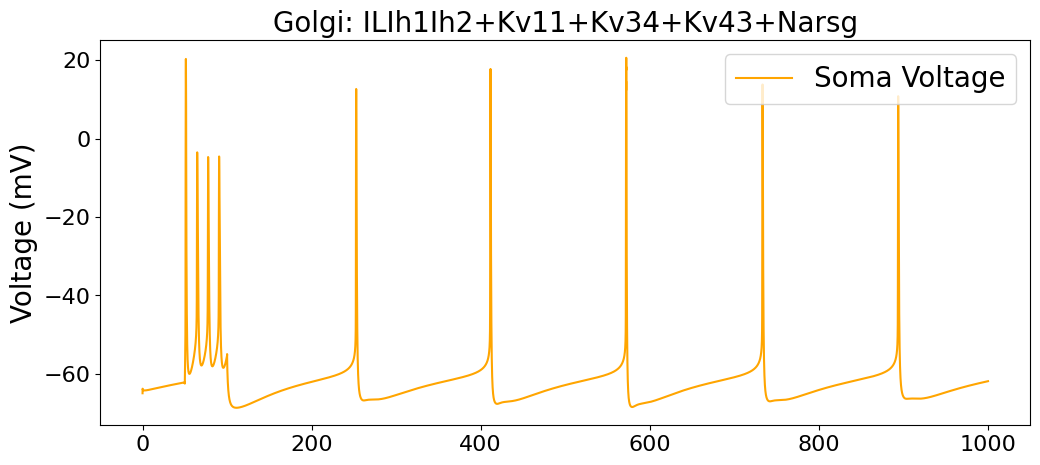

In [7]:
time = t.to_decimal(u.ms)
fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(111)

ax.plot(time, v1, label='Soma Voltage', color='orange')
ax.set_ylabel('Voltage (mV)', fontsize=20)
ax.set_title('Golgi: ILIh1Ih2+Kv11+Kv34+Kv43+Narsg', fontsize=20)
ax.tick_params(axis='both', labelsize=16)
ax.legend(loc='upper right', fontsize=20)

In [ ]:
#np.save('gol_v_data/gol_ILIh1Ih2_Kv11_Kv34_Kv43_rk4.npy',v1)

In [ ]:
'''
@bst.compile.jit(static_argnums=6)
def simulate(Ra, cm, diam, L, gl, gkv11, method='ieuler'):
    cell = Golgi(size, connection, Ra, cm, diam, L, gl, gkv11)
    cell.init_state()
    cell.reset_state()

    def step(t, *args):
        inp_a = np.full((n_neuron, n_compartments), 0.) * u.nA
        inp_a[..., 0] = 0.002 * u.nA
        inp_b = np.full((n_neuron, n_compartments), 0.) * u.nA
        cell.compute_derivative(u.math.where(t < 100 * u.ms, inp_a, inp_b))

    def save(t, *args):
        return cell.V.value

    with jax.ensure_compile_time_eval():
        dt = 0.01 * u.ms
        ts = u.math.arange(0. * u.ms, 200. * u.ms, dt)
    ts, ys, steps = dx.diffrax_solve(
        step, method, 0. * u.ms, 200. * u.ms, dt, ts,
        savefn=save, atol=1e-5,  # max_steps=200000,
    )

    return ts, ys, steps


@bst.compile.jit
def simulate2(Ra, cm, diam, L, gl, gkv11):
    cell = Golgi(size, connection, Ra, cm, diam, L, gl, gkv11)
    cell.init_state()
    cell.reset_state()

    def step_run(t):
        inp_a = np.full((n_neuron, n_compartments), 0.) * u.nA
        inp_a[..., 0] = 0.002 * u.nA
        inp_b = np.full((n_neuron, n_compartments), 0.) * u.nA
        inp = u.math.where(t < 100 * u.ms, inp_a, inp_b)
        dx.rk4_step(cell, t, inp)
        return cell.V.value

    with jax.ensure_compile_time_eval():
        dt = 0.001 * u.ms
        ts = u.math.arange(0. * u.ms, 200. * u.ms, dt)
    with bst.environ.context(dt=dt):
        ys = bst.compile.for_loop(step_run, ts)
    return ts, ys[::10], ts.size


def visualize_a_simulate(Ra, cm, diam, L, gl, gkv11):
    t0 = time.time()
    ts, ys_kvaerno5, steps = simulate(Ra, cm, diam, L, gl, gkv11, 'kvaerno5')
    print('kvaerno5', steps)
    print('time', time.time() - t0)

    t0 = time.time()
    ts, ys_ieuler, steps = simulate(Ra, cm, diam, L, gl, gkv11, 'ieuler')
    print('ieuler', steps)
    print('time', time.time() - t0)

    
    # t0 = time.time()
    # ts, ys_tsit5, steps = simulate(Ra, cm, diam, L, gl, gkv11, 'tsit5')
    # print('tsit5', steps)
    # print('time', time.time() - t0)

    # t0 = time.time()
    # ts, ys_dopri5, steps = simulate(Ra, cm, diam, L, gl, gkv11, 'dopri5')
    # print('dopri5', steps)
    # print('time', time.time() - t0)
    
    t0 = time.time()
    ts2, ys2_rk4, steps = simulate2(Ra, cm, diam, L, gl, gkv11)
    print('rk4', steps)
    print('time', time.time() - t0)

    def plot(data, ax, title):
        ax.plot(ts.to_decimal(u.ms), u.math.squeeze(data.to_decimal(u.mV)))
        plt.xlabel('Time [ms]')
        plt.ylabel('Potential [mV]')
        plt.title(title)

    fig, gs = bts.visualize.get_figure(4, 1, 6.0, 8.0)
    plot(ys_kvaerno5 - ys_ieuler, fig.add_subplot(gs[0, 0]), 'kvaerno5 - ieuler')
    #plot(ys_ieuler - ys_tsit5, fig.add_subplot(gs[0, 1]), 'ieuler - tsit5')
    #plot(ys_tsit5 - ys_dopri5, fig.add_subplot(gs[0, 2]), 'tsit5 - dopri5')
    #plot(ys_dopri5 - ys2_rk4, fig.add_subplot(gs[0, 3]), 'dopri5 - rk4')
    plot(ys2_rk4 - ys_ieuler, fig.add_subplot(gs[1, 0]), 'rk4 - ieuler')
    plot(ys_ieuler, fig.add_subplot(gs[2, 0]), 'ieuler')
    plot(ys_kvaerno5, fig.add_subplot(gs[3, 0]), 'kvaerno5')

    plt.show()


visualize_a_simulate(Ra, cm, diam, L, gl, g_test)
'''